# Ghana
***
**Author:** <font color='teal'>Andres Chamorro</font>  
**Date:** March 15, 2023  

The objective of this analysis is to construct health facility access indicators over the general population, and across the socioeconomic distribution for a set of GFF countries with available geolocalized facility level information.

**Indicators of interest**

-	Percentage of population within 2h of driving to the nearest primary care facility (population level, and by SES quintile).
-	Percentage of population within 2h of driving to the nearest district hospital (population, and by SES quintile).
-	Percentage of health facilities with direct access to an all season road.
-	Percentage of health facilities within 2km of an all season road.

**Data Sources**
- *Health facilities*: National Registry Master List, we geo-coded entries with missing coordinates
- *Administrative Boundaries*: World Bank GAUL Level 1/2
- [*Global Friction Surface (2019)*](https://developers.google.com/earth-engine/datasets/catalog/Oxford_MAP_friction_surface_2019)
- *Population 2020*: WorldPop 1km Grid Unconstrained


## Data preparation

This first section conducts some common data preparation tasks:
- Import libraries
- Load input data (this notebook was ran from the DEC JNB server)
- Merge population and friction surface raster data
- Prepare origins (population grid) and destinations (health facilities)

In [110]:
## Define Imports
import os, sys
from os.path import join
from pathlib import Path
import geopandas as gpd
import pandas as pd
import rasterio as rio
import numpy as np
from shapely.geometry import Point
import skimage.graph as graph
from rasterstats import zonal_stats

# for plotting maps
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import colorbar
from rasterio.plot import plotting_extent
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# for roads
import json
from utm_zone import epsg as epsg_get

# for facebook data
from pyquadkey2 import quadkey

# for graphs
from plotnine import ggplot, aes, geom_col, labs, theme_minimal, theme, element_blank, facet_wrap, scale_y_continuous
from mizani.formatters import percent_format
import seaborn as sns
import matplotlib.ticker as mtick

## TO DO: Work to consolidate functions onto a sinle package/module
sys.path.append('/home/wb514197/Repos/gostrocks/src') # gostrocks is used for some basic raster operations (clip and standardize)
sys.path.append('/home/wb514197/Repos/GOSTNets_Raster/src') # gostnets_raster has functions to work with friction surface
sys.path.append('/home/wb514197/Repos/INFRA_SAP') # only used to save some raster results
sys.path.append('/home/wb514197/Repos/health-equity-diagnostics/src/modules') # 

import GOSTRocks.rasterMisc as rMisc
import GOSTNetsRaster.market_access as ma
from infrasap import aggregator
from infrasap import osm_extractor as osm
from utils import download_osm_shapefiles

In [ ]:
%load_ext autoreload
%autoreload 2

Define inputs

In [39]:
##  health and admin data
iso3 = "GHA"
geocoding_output = f"{iso3}_geocoding_2.7.23.json"
input_dir = "/home/public/Data/PROJECTS/Health"
out_folder = os.path.join(input_dir, "output", iso3)
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

In [ ]:
global_admin = '/home/public/Data/GLOBAL/ADMIN/g2015_0_simplified.shp'
adm0 = gpd.read_file(global_admin)
aoi = adm0.loc[adm0.ISO3166_1_==iso3]

global_admin2 = '/home/public/Data/GLOBAL/ADMIN/Admin2_Polys.shp'
adm2 = gpd.read_file(global_admin2)
adm2 = adm2.loc[adm2.ISO3==iso3].copy()
adm2 = adm2.to_crs("EPSG:4326")
adm2.reset_index(inplace=True)

## Friction Surface and Population

global_friction_surface = "/home/public/Data/GLOBAL/INFRA/FRICTION_2020/2020_motorized_friction_surface.geotiff"
global_population = "/home/public/Data/GLOBAL/Population/WorldPop_PPP_2020/ppp_2020_1km_Aggregated.tif"
inG = rio.open(global_friction_surface)

# Clip the travel raster to AOI
out_travel_surface = os.path.join(out_folder, "travel_surface.tif")
rMisc.clipRaster(inG, aoi, out_travel_surface, crop=True, buff=0.1)

inP = rio.open(global_population)

# Clip the pop raster to AOI
out_pop = os.path.join(out_folder, "WP_2020_1km.tif")
rMisc.clipRaster(inP, aoi, out_pop, crop=True, buff=0.1)

travel_surf = rio.open(out_travel_surface)
pop_surf = rio.open(out_pop)

# standardize so that they have the same number of pixels and dimensions
out_pop_surface_std = os.path.join(out_folder, "WP_2020_1km_STD.tif")
rMisc.standardizeInputRasters(pop_surf, travel_surf, out_pop_surface_std, resampling_type="nearest")

# create a data frame of all points
pop_surf = rio.open(out_pop_surface_std)
pop = pop_surf.read(1, masked=True)
indices = list(np.ndindex(pop.shape))
xys = [Point(pop_surf.xy(ind[0], ind[1])) for ind in indices]
res_df = pd.DataFrame({
    'spatial_index': indices, 
    'xy': xys, 
    'pop': pop.flatten()
})
res_df['pointid'] = res_df.index

# create MCP object
inG_data = travel_surf.read(1) * 1000 # minutes to travel 1 meter, convert to km
# Correct no data values
inG_data[inG_data < 0] = 9999999999 # untraversable
# inG_data[inG_data < 0] = np.nan
mcp = graph.MCP_Geometric(inG_data)

Summary of health facilities by type

Hospital tag was assigned if `"hospital" or "Hospital" is in facility name`

In [ ]:
## Destinations 
# master = pd.read_csv(join(input_dir, "from_tashrik", "master lists", "Liberia MFL Adjusted.csv"), index_col=0)
master = None
geocoded = gpd.read_file(join(out_folder, geocoding_output))
geocoded = geocoded.loc[~geocoded.geometry.isna()]
geocoded.loc[:, "facilitytype"] = "None"
geocoded.loc[geocoded.orgunitlevel5.str.contains('Hospital'), 'facilitytype'] = 'hospital'
health = pd.concat([master, geocoded])
health = health.loc[health.intersects(aoi.unary_union)]
health.reset_index(inplace=True, drop=True)
hospitals = health.loc[health.facilitytype=="hospital"].copy()
geocoded.facilitytype.value_counts()

None        9121
hospital     556
Name: facilitytype, dtype: int64

## Calculate travel time to nearest health facility

We calculate driving time from every populated place (using a 1 km population grid) to the nearest health facility, using the global friction surface.​

In [45]:
## Calculate travel time to nearest health facility / hospital
res_health = ma.calculate_travel_time(travel_surf, mcp, health)[0]
res_hospital = ma.calculate_travel_time(travel_surf, mcp, hospitals)[0]

res_df.loc[:, f"tt_health"] = res_health.flatten()
res_df.loc[:, f"tt_hospital"] = res_hospital.flatten()

res_df = res_df.loc[res_df['pop']>0].copy()
res_df = res_df.loc[~(res_df['pop'].isna())].copy()
res_df.loc[:,'xy'] = res_df['xy'].apply(Point)

res_gdf = gpd.GeoDataFrame(res_df, geometry='xy', crs='EPSG:4326')
res_gdf.loc[:, 'geometry'] = res_gdf.loc[:, 'xy']

raster_path = out_pop_surface_std
aggregator.rasterize_gdf(res_gdf, 'tt_health', raster_path, os.path.join(out_folder, "tt_health.tif"), nodata=-1)
aggregator.rasterize_gdf(res_gdf, 'tt_hospital', raster_path, os.path.join(out_folder, "tt_hospital.tif"), nodata=-1)

tt_health_rio = rio.open(os.path.join(out_folder, "tt_health.tif"))
tt_health = tt_health_rio.read(1, masked=True)

tt_hospital_rio = rio.open(os.path.join(out_folder, "tt_hospital.tif"))
tt_hospital = tt_hospital_rio.read(1, masked=True)

tt_health = tt_health/60
tt_hospital = tt_hospital/60

### Travel Time Maps

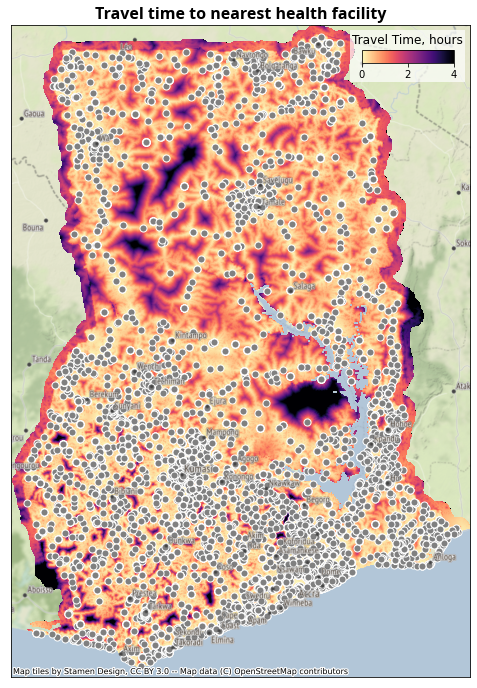

In [49]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
fonttitle = {'fontname':'Open Sans','weight':'bold','size':16}
ax.set_title("Travel time to nearest health facility", fontdict=fonttitle)
ax.get_xaxis().set_visible(False) # plt.axis('off')
ax.get_yaxis().set_visible(False)

vmin = 0
vmax = 4
cmap = 'magma_r'

ext = plotting_extent(tt_health_rio)
im = ax.imshow(tt_health, cmap=cmap, extent=ext, vmin=vmin, vmax=vmax) # norm=colors.PowerNorm(gamma=0.3)

orientation='horizontal'
alpha=1

cbbox = inset_axes(
    ax, '25%', '8%', loc = 'upper right'
)
cbbox.set_title('Travel Time, hours', y=1.0, pad=-14)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(
    axis='both', which='both',
    left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cbbox.set_facecolor([1,1,1,0.7])
# cbbox.set_axis_off()

cax = inset_axes(cbbox, '80%', '25%', loc = 'center')

cmap = plt.get_cmap(cmap)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cb = colorbar.ColorbarBase(
    ax=cax, norm=norm, alpha=alpha, cmap=cmap, orientation=orientation,
)

health.plot(ax=ax, facecolor='gray', edgecolor='white', markersize=50, alpha=1)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainLabels, crs='EPSG:4326', zorder=1)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10, alpha=0.75)

# plt.tight_layout()
plt.savefig(join(out_folder, "Friction_TT_health.png"), dpi=150, bbox_inches='tight', facecolor='white')

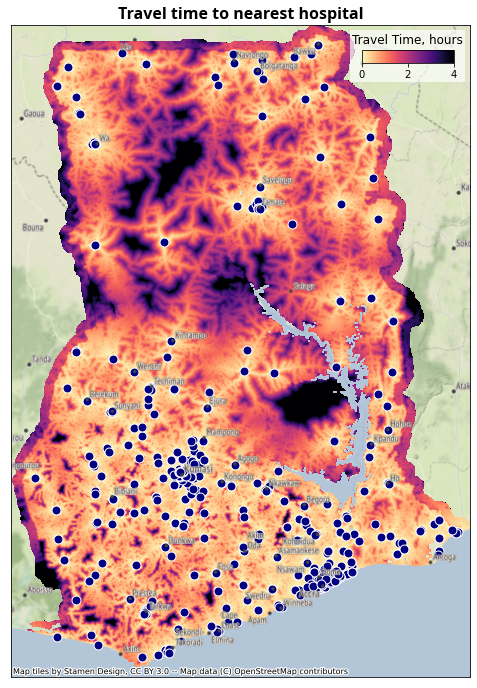

In [50]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
fonttitle = {'fontname':'Open Sans','weight':'bold','size':16}
ax.set_title("Travel time to nearest hospital", fontdict=fonttitle)
ax.get_xaxis().set_visible(False) # plt.axis('off')
ax.get_yaxis().set_visible(False)


vmin = 0
vmax = 4
cmap = 'magma_r'

ext = plotting_extent(tt_health_rio)
im = ax.imshow(tt_hospital, cmap=cmap, extent=ext, vmin=vmin, vmax=vmax) # norm=colors.PowerNorm(gamma=0.3)

orientation='horizontal'
alpha=1

cbbox = inset_axes(
    ax, '25%', '8%', loc = 'upper right'
)
cbbox.set_title('Travel Time, hours', y=1.0, pad=-14)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.tick_params(
    axis='both', which='both',
    left=False, top=False, right=False, bottom=False, 
    labelleft=False, labeltop=False, labelright=False, labelbottom=False
)
cbbox.set_facecolor([1,1,1,0.7])

cax = inset_axes(cbbox, '80%', '25%', loc = 'center')

cmap = plt.get_cmap(cmap)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cb = colorbar.ColorbarBase(
    ax=cax, norm=norm, alpha=alpha, cmap=cmap, orientation=orientation,
)

hospitals.plot(ax=ax, facecolor='navy', edgecolor='white', markersize=80, alpha=1)
# ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainLabels, crs='EPSG:4326', zorder=1)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10, alpha=0.75)
plt.savefig(join(out_folder, "Friction_TT_hospital.png"), dpi=150, bbox_inches='tight', facecolor='white')


## Summarize population within 2 hours

In [51]:
pop_120_heatlh = pop*(tt_health<=2)
pop_120_hospital = pop*(tt_hospital<=2)

zs_pop = pd.DataFrame(zonal_stats(adm2, pop.filled(), affine=pop_surf.transform, stats='sum', nodata=pop_surf.nodata)).rename(columns={'sum':'pop'})
zs_lt_120_health = pd.DataFrame(zonal_stats(adm2, pop_120_heatlh.filled(), affine=pop_surf.transform, stats='sum', nodata=pop_surf.nodata)).rename(columns={'sum':'pop_120_health'})
zs_lt_120_hospital = pd.DataFrame(zonal_stats(adm2, pop_120_hospital.filled(), affine=pop_surf.transform, stats='sum', nodata=pop_surf.nodata)).rename(columns={'sum':'pop_120_hospital'})
zs = zs_pop.join(zs_lt_120_health).join(zs_lt_120_hospital)

zs.loc[:, "health_pct"] = zs.loc[:, "pop_120_health"]/zs.loc[:, "pop"]
zs.loc[:, "hospital_pct"] = zs.loc[:, "pop_120_hospital"]/zs.loc[:, "pop"]
res = adm2.join(zs)

Summary stats

In [67]:
print(f"Summary of % of pop. within 2 hr. of health facility \n {res.health_pct.describe()}")
print(f"Summary of % of pop. within 2 hr. of hospital \n {res.hospital_pct.describe()}")

Summary of % of pop. within 2 hr. of health facility 
 count    110.000000
mean       0.991290
std        0.025454
min        0.779150
25%        0.992899
50%        0.998995
75%        1.000000
max        1.000000
Name: health_pct, dtype: float64
Summary of % of pop. within 2 hr. of hospital 
 count    110.000000
mean       0.975085
std        0.055193
min        0.670728
25%        0.980969
50%        0.996126
75%        1.000000
max        1.000000
Name: hospital_pct, dtype: float64


### Accessibility Maps (Share of pop.)

Percentage of population within 2 hours of driving to the nearest primary care facility, by district (admin-2 level).​

This indicator considers clinics, health centers, and hospitals.

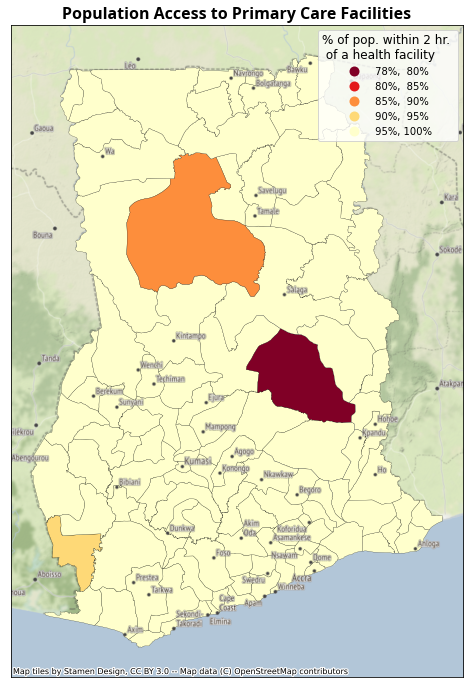

In [88]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
fonttitle = {'fontname':'Open Sans','weight':'bold','size':16}
ax.set_title("Population Access to Primary Care Facilities", fontdict=fonttitle)
ax.get_xaxis().set_visible(False) # plt.axis('off')
ax.get_yaxis().set_visible(False)

res.plot(
    ax=ax, column='health_pct', cmap='YlOrRd_r', legend=True,
    scheme='user_defined', alpha=1, linewidth=0.2, edgecolor='black', 
    classification_kwds = {'bins': [0.8,0.85,0.9,0.95,1]},
    legend_kwds = {
        'title': "% of pop. within 2 hr. \n of a health facility", 
        'fontsize': 10,
        'fmt': "{:.0%}",
        'title_fontsize': 12
    }
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainLabels, crs='EPSG:4326', zorder=1)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10, alpha=0.75)

plt.savefig(os.path.join(out_folder, "Health_Access.png"), dpi=150, bbox_inches='tight', facecolor='white')

Percentage of population within 2 hours of driving to the nearest hospital, by district (admin-2 level).​

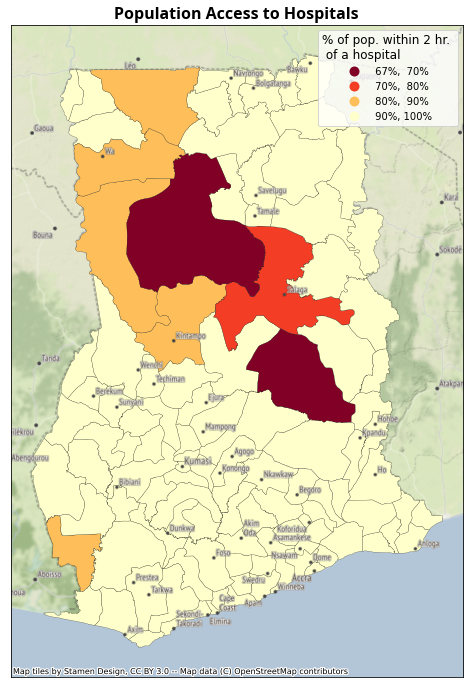

In [93]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
fonttitle = {'fontname':'Open Sans','weight':'bold','size':16}
ax.set_title("Population Access to Hospitals", fontdict=fonttitle)
ax.get_xaxis().set_visible(False) # plt.axis('off')
ax.get_yaxis().set_visible(False)

res.plot(
    ax=ax, column='hospital_pct', cmap='YlOrRd_r', legend=True,
    scheme='user_defined', alpha=1, linewidth=0.2, edgecolor='black', 
    classification_kwds = {'bins': [0.7,0.8,0.9,1]},
    legend_kwds = {
        'title': "% of pop. within 2 hr. \n of a hospital", 
        'fontsize': 10,
        'fmt': "{:.0%}",
        'title_fontsize': 12
    }
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainLabels, crs='EPSG:4326', zorder=1)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10, alpha=0.75)

plt.savefig(os.path.join(out_folder, "Hospitals_Access.png"), dpi=150, bbox_inches='tight', facecolor='white')

## Access to roads

Percentage of health facilities having direct access to an all-season road, by district (admin-2 level).​

All-season road defined as primary, secondary or tertiary using the OpenStreetMap classification.​

Direct access defined as being within 100 meters of a road.​

### Load OSM roads and define classification 
``` python
{
    'motorway': 'OSMLR level 1',
    'motorway_link': 'OSMLR level 1',
    'trunk': 'OSMLR level 1',
    'trunk_link': 'OSMLR level 1',
    'primary': 'OSMLR level 1',
    'primary_link': 'OSMLR level 1',
    'secondary': 'OSMLR level 2',
    'secondary_link': 'OSMLR level 2',
    'tertiary': 'OSMLR level 2',
    'tertiary_link': 'OSMLR level 2',
    'unclassified': 'OSMLR level 3',
    'unclassified_link': 'OSMLR level 3',
    'residential': 'OSMLR level 3',
    'residential_link': 'OSMLR level 3',
    'track': 'OSMLR level 4',
    'service': 'OSMLR level 4'
}
 ```

In [115]:
download_osm_shapefiles('africa', 'ghana', Path(join(input_dir, 'osm', iso3)))

In [121]:
roads = gpd.read_file(join(input_dir, 'osm', iso3, 'gis_osm_roads_free_1.shp'))

adm2_json = json.loads(adm2.to_json())
epsg = epsg_get(adm2_json)

roads = roads.to_crs(epsg)
roads['OSMLR'] = roads['fclass'].map(osm.OSMLR_Classes)

def get_num(x):
    try:
        return(int(x))
    except:
        return(5)
roads['OSMLR_num'] = roads['OSMLR'].apply(lambda x: get_num(str(x)[-1]))

## Calculate buffers
roads_100m = roads.copy()
roads_100m['geometry'] = roads_100m['geometry'].apply(lambda x: x.buffer(100))

roads_2km = roads.copy()
roads_2km['geometry'] = roads_2km['geometry'].apply(lambda x: x.buffer(2000))

health = health.to_crs(epsg)
# hospitals = hospitals.to_crs(epsg)

## Intersect roads and buffer
# roads_1_100m = roads_100m.loc[roads_100m.OSMLR_num<=1].unary_union
roads_2_100m = roads_100m.loc[roads_100m.OSMLR_num<=2].unary_union
# roads_3 = roads.loc[roads.OSMLR_num<=3].unary_union
# roads_4 = roads.loc[roads.OSMLR_num<=4].unary_union

# health.loc[:, "bool_1_100m"] = health.intersects(roads_1_100m)
health.loc[:, "bool_2_100m"] = health.intersects(roads_2_100m)
# health.loc[:, "bool_3"] = health.intersects(roads_3)
# health.loc[:, "bool_4"] = health.intersects(roads_4)

# roads_1_2km = roads_2km.loc[roads_2km.OSMLR_num<=1].unary_union
roads_2_2km = roads_2km.loc[roads_2km.OSMLR_num<=2].unary_union
# roads_3 = roads.loc[roads.OSMLR_num<=3].unary_union
# roads_4 = roads.loc[roads.OSMLR_num<=4].unary_union

# health.loc[:, "bool_1_2km"] = health.intersects(roads_1_2km)
health.loc[:, "bool_2_2km"] = health.intersects(roads_2_2km)
# health.loc[:, "bool_3"] = health.intersects(roads_3)
# health.loc[:, "bool_4"] = health.intersects(roads_4)

health = health.to_crs(adm2.crs)
facilities = gpd.sjoin(health, adm2[['OBJECTID', 'WB_ADM2_CO', 'geometry']], how='left')

## Get percentages
# res_osmlr = facilities[['bool_1_100m','bool_2_100m','bool_1_2km','bool_2_2km','WB_ADM2_CO']].groupby('WB_ADM2_CO').sum()
res_osmlr = facilities[['bool_2_100m','bool_2_2km','WB_ADM2_CO']].groupby('WB_ADM2_CO').sum()
res_count = facilities[['WB_ADM2_CO','bool_2_100m']].groupby('WB_ADM2_CO').count().rename(columns={'bool_2_100m':'count'})
res_osmlr_pct = res_osmlr.apply(lambda x: x/res_count['count'])

res = res.merge(res_osmlr_pct, left_on="WB_ADM2_CO", right_index=True)

### Maps of Access to Roads

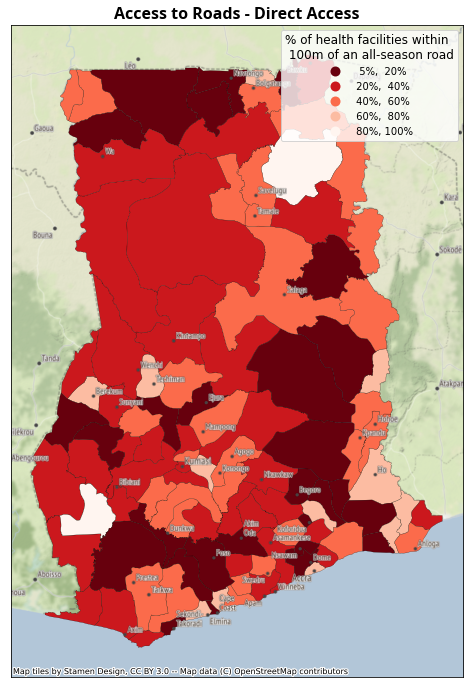

In [140]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
fonttitle = {'fontname':'Open Sans','weight':'bold','size':16}
ax.set_title("Access to Roads - Direct Access", fontdict=fonttitle)
ax.get_xaxis().set_visible(False) # plt.axis('off')
ax.get_yaxis().set_visible(False)

res.plot(
    ax=ax, column='bool_2_100m', cmap='Reds_r', legend=True,
    scheme='user_defined', alpha=1, linewidth=0.2, edgecolor='black',
    classification_kwds = {'bins': [0.2,0.4,0.6,0.8,1]},
    legend_kwds = {
        'title': "% of health facilities within \n 100m of an all-season road", 
        'fontsize': 10,
        'fmt': "{:.0%}",
        'title_fontsize': 12
    }
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainLabels, crs='EPSG:4326', zorder=1)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10, alpha=0.75)

plt.savefig(os.path.join(out_folder, "Roads_100m.png"), dpi=150, bbox_inches='tight', facecolor='white')

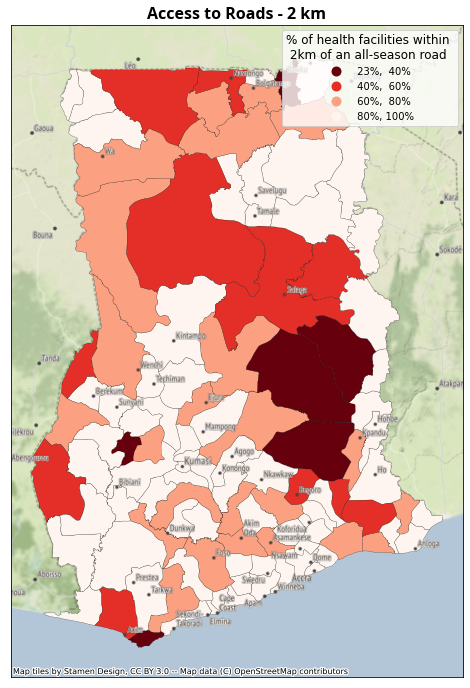

In [142]:
figsize = (12,12)
fig, ax = plt.subplots(1, 1,  figsize = figsize)
fonttitle = {'fontname':'Open Sans','weight':'bold','size':16}
ax.set_title("Access to Roads - 2 km", fontdict=fonttitle)
ax.get_xaxis().set_visible(False) # plt.axis('off')
ax.get_yaxis().set_visible(False)

res.plot(
    ax=ax, column='bool_2_2km', cmap='Reds_r', legend=True, linewidth=0.2, edgecolor='black',
    scheme='user_defined', alpha=1,
    classification_kwds = {'bins': [0.4,0.6,0.8,1]},
    legend_kwds = {
        'title': "% of health facilities within \n 2km of an all-season road", 
        'fontsize': 10,
        'fmt': "{:.0%}",
        'title_fontsize': 12
    }
)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TerrainLabels, crs='EPSG:4326', zorder=1)
ctx.add_basemap(ax, source=ctx.providers.Stamen.Terrain, crs='EPSG:4326', zorder=-10, alpha=0.75)

plt.savefig(os.path.join(out_folder, "Roads_2km.png"), dpi=150, bbox_inches='tight', facecolor='white')

## Access to health disaggregated by wealth quintile

Categorize population grid by wealth quintiles, and then summarize the population with access to health (within 2 hours of health facility or hospital)

In [130]:
fb = pd.read_csv(os.path.join(input_dir, 'facebook', f'{iso3.lower()}_relative_wealth_index.csv'))
fb_geoms = [Point(xy) for xy in zip(fb.longitude, fb.latitude)]
fb_geo = gpd.GeoDataFrame(fb, crs='EPSG:4326', geometry=fb_geoms)

### Summarize access with facebook grid
fb_zs = pd.DataFrame(zonal_stats(fb_geo, tt_health.filled(), affine=tt_health_rio.transform, stats='mean', nodata=tt_health_rio.nodata)).rename(columns={'mean':'tt_health'})
fb_zs_hosp = pd.DataFrame(zonal_stats(fb_geo, tt_hospital.filled(), affine=tt_hospital_rio.transform, stats='mean', nodata=tt_hospital_rio.nodata)).rename(columns={'mean':'tt_hospital'})

fb_geo = fb_geo.join(fb_zs).join(fb_zs_hosp)
fb_geo.loc[:, "rwi_cut"] = pd.qcut(fb_geo['rwi'], [0, .2, .4, .6, .8, 1.], labels=['lowest', 'second-lowest', 'middle', 'second-highest', 'highest'])
fb_geo = gpd.sjoin(fb_geo, adm2[['WB_ADM2_CO', 'WB_ADM2_NA', 'WB_ADM1_NA', 'geometry']])

### Merge population from Facebook
population = pd.read_csv(join(input_dir, 'facebook', f'{iso3.lower()}_general_2020.csv'))
population = population.rename(columns={f'{iso3.lower()}_general_2020': 'pop_2020'})
population['quadkey'] = population.apply(lambda x: str(quadkey.from_geo((x['latitude'], x['longitude']), 14)), axis=1)

bing_tile_z14_pop = population.groupby('quadkey', as_index=False)['pop_2020'].sum()
fb_geo['quadkey'] = fb_geo.apply(lambda x: str(quadkey.from_geo((x['latitude'], x['longitude']), 14)), axis=1)
rwi = fb_geo.merge(bing_tile_z14_pop[['quadkey', 'pop_2020']], on='quadkey', how='inner')

rwi.loc[:, "tt_health_bool"] = rwi.tt_health<=2
rwi.loc[:, "tt_hospital_bool"] = rwi.tt_hospital<=2

### Aggregate at country level
rwi_pop_adm0 = rwi[['rwi_cut', 'pop_2020']].groupby(['rwi_cut']).sum()
rwi_health_adm0 = rwi.loc[rwi.tt_health_bool==True, ['rwi_cut', 'pop_2020']].groupby(['rwi_cut']).sum().rename(columns={'pop_2020':'pop_120_health'})
rwi_hospital_adm0 = rwi.loc[rwi.tt_hospital_bool==True, ['rwi_cut', 'pop_2020']].groupby(['rwi_cut']).sum().rename(columns={'pop_2020':'pop_120_hospital'})
res_rwi_adm0 = rwi_pop_adm0.join(rwi_health_adm0).join(rwi_hospital_adm0)
res_rwi_adm0.loc[:, "health_pct"] = res_rwi_adm0['pop_120_health']/res_rwi_adm0['pop_2020']
res_rwi_adm0.loc[:, "hospital_pct"] = res_rwi_adm0['pop_120_hospital']/res_rwi_adm0['pop_2020']
res_rwi_adm0.reset_index(inplace=True)

res_rwi_adm0 = res_rwi_adm0[['rwi_cut', 'health_pct', 'hospital_pct']].melt(id_vars='rwi_cut', var_name="type", value_name='pct')
res_rwi_adm0.type = res_rwi_adm0.type.str.strip("_pct")
res_rwi_adm0.loc[res_rwi_adm0.type=="health", "type"] = 'health facility'

### Chart access to health by wealth quintile

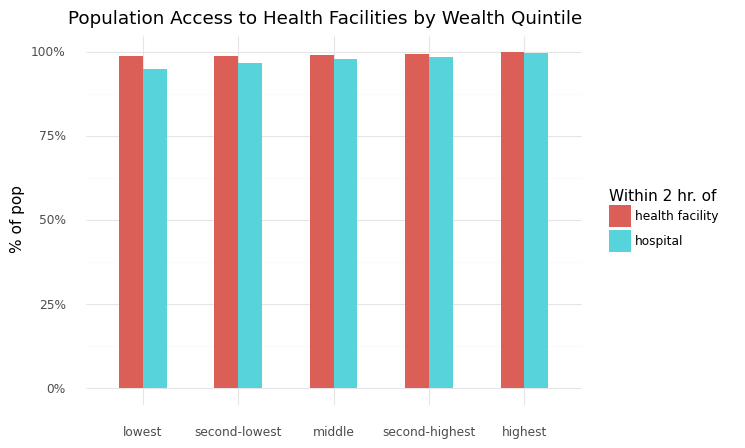

<ggplot: (8763572091505)>

In [131]:
(
ggplot(res_rwi_adm0, aes(x="rwi_cut", y="pct", fill="type"))
    + geom_col(width=0.5, stat='identity', position='dodge')
    + labs(
        x="", y="% of pop", title="Population Access to Health Facilities by Wealth Quintile",
        fill="Within 2 hr. of"
    )
    + theme_minimal()
    + scale_y_continuous(labels=percent_format())
    # + theme(legend_position='bottom')
)

### Aggregate to province-level (admin 1)

In [143]:
rwi_pop = rwi[['WB_ADM1_NA', 'rwi_cut', 'pop_2020']].groupby(['WB_ADM1_NA', 'rwi_cut']).sum()
rwi_health = rwi.loc[rwi.tt_health_bool==True, ['WB_ADM1_NA', 'rwi_cut', 'pop_2020']].groupby(['WB_ADM1_NA', 'rwi_cut']).sum().rename(columns={'pop_2020':'pop_120_health'})
rwi_hospital = rwi.loc[rwi.tt_hospital_bool==True, ['WB_ADM1_NA', 'rwi_cut', 'pop_2020']].groupby(['WB_ADM1_NA', 'rwi_cut']).sum().rename(columns={'pop_2020':'pop_120_hospital'})
res_rwi = rwi_pop.join(rwi_health).join(rwi_hospital)
res_rwi.reset_index(inplace=True)

res_rwi.loc[:, "health_pct"] = res_rwi['pop_120_health']/res_rwi['pop_2020']
res_rwi.loc[:, "hospital_pct"] = res_rwi['pop_120_hospital']/res_rwi['pop_2020']

### Chart access to health by wealth quintile, by province

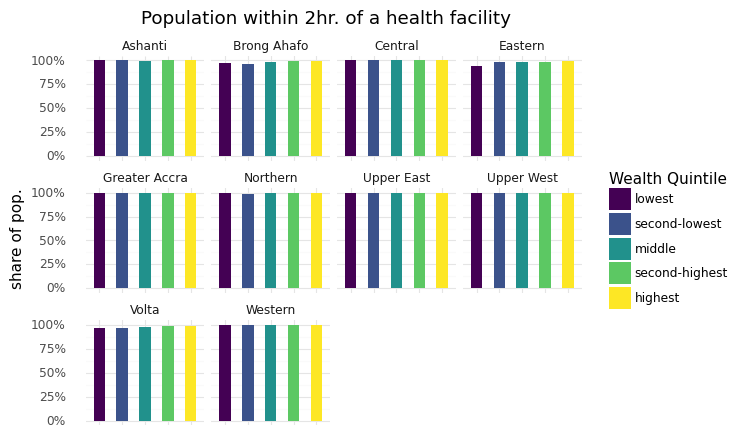

<ggplot: (8763523855289)>

In [144]:
(
ggplot(res_rwi, aes(x="rwi_cut", y="health_pct", fill="rwi_cut"))
    + geom_col(width=0.5)
    + labs(
        x="", y="share of pop.", title="Population within 2hr. of a health facility",
        fill="Wealth Quintile"
    )
    + theme_minimal()
    + theme(axis_text_x=element_blank(), axis_ticks_major_x=element_blank())
    + facet_wrap("WB_ADM1_NA")
    + scale_y_continuous(labels=percent_format())
)

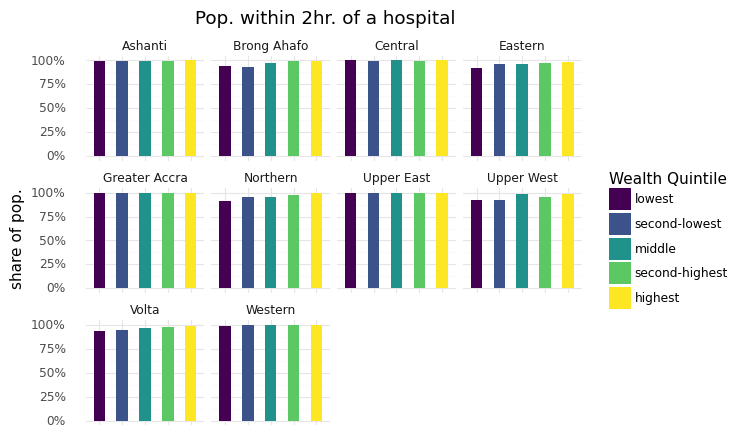

<ggplot: (8763523947001)>

In [145]:
(
ggplot(res_rwi, aes(x="rwi_cut", y="hospital_pct", fill="rwi_cut"))
    + geom_col(width=0.5)
    + labs(
        x="", y="share of pop.", title="Pop. within 2hr. of a hospital",
        fill="Wealth Quintile"
    )
    + theme_minimal()
    + theme(axis_text_x=element_blank(), axis_ticks_major_x=element_blank())
    + facet_wrap("WB_ADM1_NA")
    + scale_y_continuous(labels=percent_format())
)

In [158]:
res.to_file(join(out_folder, "stats_adm2.json"), driver='GeoJSON')
rwi.rwi_cut = rwi.rwi_cut.astype('str')
rwi.to_file(join(out_folder, "stats_rwi.json"), driver='GeoJSON')